## Importando bibliotecas e validando base de dados

In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import re
import string
import nltk
import pickle
import matplotlib.pyplot as plt
%matplotlib inline    

In [41]:
df1 = pd.read_csv("base/base_dados_1.csv", delimiter=",")  # Base por Pelle [2017]
df2 = pd.read_csv("base/base_dados_2.csv", delimiter=";")  # Base por Fortuna [2019]



df = pd.concat([df1, df2], ignore_index=True)

In [42]:
df1.shape

(1242, 2)

In [43]:
df2.shape

(5670, 2)

In [44]:
df.head()

,hatespeech,text
0,yes,Votaram no PEZAO Agora tomem no CZAO
1,no,cuidado com a poupanca pessoal Lembram o que a...
2,no,Sabe o que eu acho engracado os nossos governa...
3,yes,os cariocas tem o que merecem um pessoal que s...
4,no,Podiam retirar dos lucros dos bancos


## Balanceando amostras

In [45]:
Counter(df['hatespeech'])

Counter({'yes': 2202, 'no': 4710})

In [46]:
cut = 2202
df_yes = df[df['hatespeech'] == 'yes'].head(cut)
df_no = df[df['hatespeech'] == 'no'].head(cut)

df_cut=pd.concat([df_yes, df_no])

In [47]:
Counter(df_cut['hatespeech'])

Counter({'yes': 2202, 'no': 2202})

In [48]:
df_cut = df

## Limpando Dados

In [49]:
list_stops_words = []

In [50]:
# O Natural Language Toolkit necessita de bases de dados/bibliotecas que possam categorizar informações em pt-BR.
nltk.download('stopwords')
nltk.download('rslp')
nltk.download('punkt')
stopwords = nltk.corpus.stopwords.words('portuguese')
#Objeto que extrai o radical de palavras.
lemmatizer = nltk.stem.RSLPStemmer()
    print(stopwords)

['de', 'a', 'o', 'que', 'e', 'é', 'do', 'da', 'em', 'um', 'para', 'com', 'não', 'uma', 'os', 'no', 'se', 'na', 'por', 'mais', 'as', 'dos', 'como', 'mas', 'ao', 'ele', 'das', 'à', 'seu', 'sua', 'ou', 'quando', 'muito', 'nos', 'já', 'eu', 'também', 'só', 'pelo', 'pela', 'até', 'isso', 'ela', 'entre', 'depois', 'sem', 'mesmo', 'aos', 'seus', 'quem', 'nas', 'me', 'esse', 'eles', 'você', 'essa', 'num', 'nem', 'suas', 'meu', 'às', 'minha', 'numa', 'pelos', 'elas', 'qual', 'nós', 'lhe', 'deles', 'essas', 'esses', 'pelas', 'este', 'dele', 'tu', 'te', 'vocês', 'vos', 'lhes', 'meus', 'minhas', 'teu', 'tua', 'teus', 'tuas', 'nosso', 'nossa', 'nossos', 'nossas', 'dela', 'delas', 'esta', 'estes', 'estas', 'aquele', 'aquela', 'aqueles', 'aquelas', 'isto', 'aquilo', 'estou', 'está', 'estamos', 'estão', 'estive', 'esteve', 'estivemos', 'estiveram', 'estava', 'estávamos', 'estavam', 'estivera', 'estivéramos', 'esteja', 'estejamos', 'estejam', 'estivesse', 'estivéssemos', 'estivessem', 'estiver', 'estiv

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bruno\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\bruno\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bruno\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [51]:
def clean_text(text):
    text_new = text.lower()
    text_new = text_new.replace('\r\n'," ")
    text_new = re.sub(r'(http|https)\S+', "", text_new)
    text_new = re.sub(r'[@]\w+','',text_new)
    text_new = re.sub(r'[^\w\s]|[_-]|[0-9]','', text_new)
    text_new = text_new.split(" ")
    text_new = [x for x in text_new if x not in stopwords]
    text_new.remove(' ') if ' ' in text_new else None
    text_new = [c.stem(x) for x in text_new if x]
    return " ".join(text_new)

In [52]:
df_cut['text_clean'] = df['text'].apply(lambda x: clean_text(x))


In [75]:
df_cut.head(10)

,hatespeech,text,text_clean
0,yes,Votaram no PEZAO Agora tomem no CZAO,vot peza agor tom cza
1,no,cuidado com a poupanca pessoal Lembram o que a...,cuid poupanc pessoal lembr acontec epoc coll ne
2,no,Sabe o que eu acho engracado os nossos governa...,sab ach engrac govern nao pens cort regal bene...
3,yes,os cariocas tem o que merecem um pessoal que s...,carioc merec pessoal so sab tom banh sol pra v...
4,no,Podiam retirar dos lucros dos bancos,pod retir lucr banc
5,no,CADE O GALVAO PRA NARRAR AGORA FALIIIIUUUUUU...,cad galva pra narr agor faliiiiuuuuuuu faliiiu...
6,no,Nao e possivel que deputados tenham tantos car...,nao possi deput tant carg comission disp tip c...
7,no,Sejam honestos aprovem o projeto original vamo...,honest aprov projet orig vam acab farr brasil
8,no,Nao a pizza anunciada de anistia do caixa Sim...,nao pizz anunci anist caix sim divulgaca list ...
9,no,quem ja viu bandidos fazendo leis contra antic...,ja viu band faz lei contr anticorrupca


In [54]:
df_cut['text'].shape


(6912,)

In [55]:

X = df_cut['text_clean']
Y = df_cut['hatespeech']
vectorizer = CountVectorizer()
X_vectorizer = vectorizer.fit_transform(X)


x_treino, x_validacao, y_treino, y_validacao = train_test_split(X_vectorizer.toarray(), Y, test_size=0.2, random_state=42)

In [56]:
X[0]

'vot peza agor tom cza'

In [57]:
vectorizer.get_feature_names_out()

array(['aa', 'aaa', 'aaaa', ..., 'útel', 'úter', 'útil'], dtype=object)

In [58]:
X_vectorizer.shape

(6912, 8693)

In [59]:
classificadores = [LogisticRegression(), MultinomialNB(), LinearSVC()]

In [76]:
TOTAL_KFOLDS = 10
metricas = ['accuracy', 'balanced_accuracy', 'roc_auc']
nomes = ['Logistic Regression', 'Multinomial Naive Bayes', 'Linear SVC (SVM)']
modelos = {}
resultados = []
resultados_testes_metricas = {}
resultados_validacao = {}


## Treina modelos

Realizao treinamento e teste baseado em cada classificador, avalia  erro e score baseado nas métricas espacificadas


In [61]:
for i in range(len(classificadores)):
    scores = cross_validate(classificadores[i], x_treino, y_treino, scoring=metricas, cv=TOTAL_KFOLDS)
    resultados_testes_metricas[nomes[i]] = scores
print(resultados_testes_metricas)

{'Logistic Regression': {'fit_time': array([3.99950886, 4.05840898, 3.89559317, 3.7808187 , 3.7542882 ,
       3.62513614, 4.1151979 , 4.17548895, 3.80551362, 3.92038178]), 'score_time': array([0.02981925, 0.03691697, 0.03474331, 0.03212833, 0.03219795,
       0.03517699, 0.03012729, 0.02994537, 0.03024673, 0.03504348]), 'test_accuracy': array([0.74321881, 0.73417722, 0.75587703, 0.76130199, 0.77034358,
       0.76491863, 0.7721519 , 0.7323689 , 0.74141049, 0.76449275]), 'test_balanced_accuracy': array([0.66457678, 0.65643446, 0.67833708, 0.69099722, 0.69185612,
       0.69804021, 0.7092134 , 0.65941206, 0.67046575, 0.68782671]), 'test_roc_auc': array([0.75262921, 0.76134082, 0.786397  , 0.75837242, 0.76352583,
       0.77517701, 0.75256177, 0.72005796, 0.77865743, 0.76231749])}, 'Multinomial Naive Bayes': {'fit_time': array([0.8903625 , 0.8852303 , 0.88682532, 0.88527322, 0.88495636,
       0.88404894, 0.8803041 , 0.88538074, 0.88691258, 0.88500285]), 'score_time': array([0.03410792, 

## Realiza a predição com cada um dos classificadores

A validação Utilizando a base de validação com dados que não estão entre aqueles
#utilizados para treino pelos classificadores. Além disso, armazena os valores de acurácia obtidos
#para cada class.

In [62]:
for i in range(len(classificadores)):
    modelos[nomes[i]] = classificadores[i].fit(x_treino, y_treino)
    results = classificadores[i].predict(x_validacao)
    acuracia = accuracy_score(y_validacao, results)
    resultados_validacao[nomes[i]] = acuracia
    
print(f"Acurácia: {resultados_validacao}")

Acurácia: {'Logistic Regression': 0.7505422993492408, 'Multinomial Naive Bayes': 0.7447577729573391, 'Linear SVC (SVM)': 0.7194504699927693}


In [63]:
input_example = 'vocês são muito legais'

input_example = clean_text(input_example)
print (input_example)

input_predict = vectorizer.transform([input_example])
print(input_predict.toarray())

legal
[[0 0 0 ... 0 0 0]]


In [64]:
input_predict.shape

(1, 8693)

In [65]:
result = modelos['Logistic Regression'].predict(input_predict.toarray())
print(result[0])

no


In [66]:
result = modelos[ 'Multinomial Naive Bayes'].predict(input_predict.toarray())
print(result[0])

no


In [67]:
result = modelos['Linear SVC (SVM)'].predict(input_predict.toarray())
print(result[0])

no


In [68]:
#Cria um gráfico a partir dos parâmetros de abscissas e ordenadas passados como parâmetro e salva num arquivo PNG na raiz do programa.
def mostrarGraficoLinhas(y_linsvc, y_multnvb, y_lreg, x_kfolds, y_values, x_label, y_label):
    figure(num=None, figsize=(8, 6))
    plt.plot(x_kfolds, y_lreg, '.', label='Logistic regression',linestyle='-')  # Recebe dois arrays, um sera do K e outro dos resultados
    plt.plot(x_kfolds, y_multnvb, '.', label='Multinomial Naive Bayes', linestyle='-')
    plt.plot(x_kfolds, y_linsvc, '.', label='LinearSVC', linestyle='-')
    plt.ylim(0, 1)
    plt.yticks(y_values)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(x_label + " vs. " + y_label)
    plt.legend()
    plt.savefig('teste-' + y_label + '.png')
    plt.show()

In [69]:
resultados_testes_metricas['Logistic Regression']

{'fit_time': array([3.99950886, 4.05840898, 3.89559317, 3.7808187 , 3.7542882 ,
        3.62513614, 4.1151979 , 4.17548895, 3.80551362, 3.92038178]),
 'score_time': array([0.02981925, 0.03691697, 0.03474331, 0.03212833, 0.03219795,
        0.03517699, 0.03012729, 0.02994537, 0.03024673, 0.03504348]),
 'test_accuracy': array([0.74321881, 0.73417722, 0.75587703, 0.76130199, 0.77034358,
        0.76491863, 0.7721519 , 0.7323689 , 0.74141049, 0.76449275]),
 'test_balanced_accuracy': array([0.66457678, 0.65643446, 0.67833708, 0.69099722, 0.69185612,
        0.69804021, 0.7092134 , 0.65941206, 0.67046575, 0.68782671]),
 'test_roc_auc': array([0.75262921, 0.76134082, 0.786397  , 0.75837242, 0.76352583,
        0.77517701, 0.75256177, 0.72005796, 0.77865743, 0.76231749])}

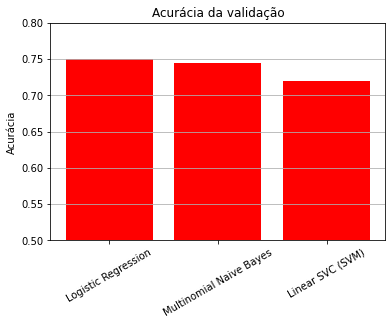

In [70]:
resultados_validacao.values
plt.bar(nomes,resultados_validacao.values(), align='center', color = 'red')
plt.xticks(np.arange(len(nomes)), nomes, rotation=30)
plt.title('Acurácia da validação')
plt.ylabel('Acurácia')
plt.yticks(np.arange(0.5, 0.8, step=0.05))
plt.ylim((0.5,0.8))
plt.grid(axis='y')
plt.savefig('graficos/validacao-acuracia.png')

In [71]:
result_metricas = []
for chave, valor in resultados_testes_metricas.items():
    result_metricas.append(valor['test_' + metricas[i]])

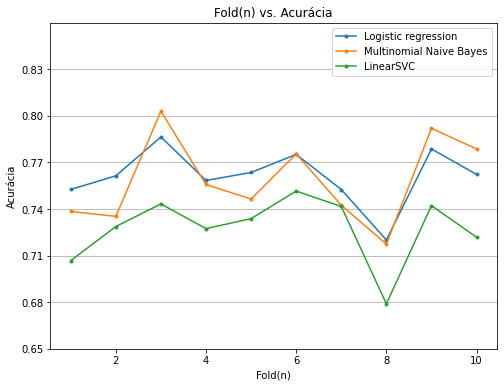

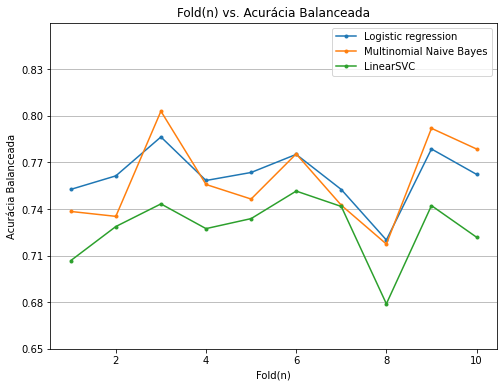

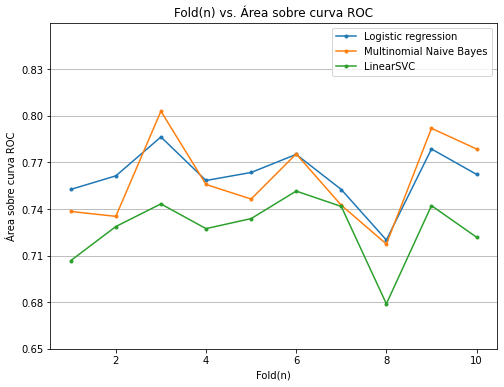

In [72]:
label = ['Acurácia', 'Acurácia Balanceada', 'Área sobre curva ROC']
kfolds = [i+1 for i in range(TOTAL_KFOLDS)]
for i in range(len(metricas)):
    plt.figure(num=None, figsize=(8, 6))
    plt.plot(kfolds, result_metricas[0], '.', label='Logistic regression',linestyle='-')  # Recebe dois arrays, um sera do K e outro dos resultados
    plt.plot(kfolds, result_metricas[1], '.', label='Multinomial Naive Bayes', linestyle='-')
    plt.plot(kfolds, result_metricas[2], '.', label='LinearSVC', linestyle='-')
    plt.ylim(0, 1)
    plt.yticks(np.arange(0.5, 0.85, step=0.03))
    plt.ylim((0.65,0.86))
    plt.xlabel("Fold(n)")
    plt.ylabel(label[i])
    plt.title("Fold(n) vs. " + label[i])
    plt.legend()
    plt.grid(axis='y')
    plt.savefig(f'graficos/{label[i]}.png')

In [73]:
Logistic_Regression = [n for n in resultados_testes_metricas['Logistic Regression']['fit_time']]
Multinomial_Naive_Bayes = [n for n in resultados_testes_metricas['Multinomial Naive Bayes']['fit_time']]
Linear_SVC = [n for n in resultados_testes_metricas['Linear SVC (SVM)']['fit_time']]


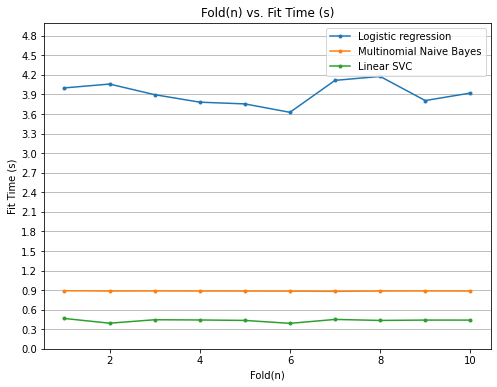

In [74]:
label = ['Acurácia', 'Acurácia Balanceada', 'Área sobre curva ROC']

plt.figure(num=None, figsize=(8, 6))
plt.plot(kfolds, Logistic_Regression, '.', label='Logistic regression',linestyle='-')  # Recebe dois arrays, um sera do K e outro dos resultados
plt.plot(kfolds, Multinomial_Naive_Bayes, '.', label='Multinomial Naive Bayes', linestyle='-')
plt.plot(kfolds, Linear_SVC, '.', label='Linear SVC', linestyle='-')
plt.ylim(0, 5)
plt.yticks(np.arange(0, 5, step=0.3))
#plt.ylim((0,0.6))
plt.xlabel("Fold(n)")
plt.ylabel("Fit Time (s)")
plt.title("Fold(n) vs. Fit Time (s)")
plt.legend()
plt.grid(axis='y')
plt.savefig('graficos/Fit-Time.png')